# Project 4: Intel Image Classification

### Clarence Alvarez, Laura Minter, Nick Van Bergen

## Exploratory Data Analysis

1. pull in a few images as display
1. Make some comments on them (color, edges, ...)
1. Pull in a single image as an array, look at shaping, etc.



In [2]:
%config Completer.use_jedi = False

In [62]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from tensorflow.keras import utils
from tensorflow import keras

import os

# importing matplotlib image modules
import matplotlib.image as mpimg

from PIL import ImageOps, Image


## Exploratory data analysis

In [4]:
os.getcwd()

'C:\\Users\\clare\\Documents\\GA\\Projects\\project-4'

Check that we don't have any other filetypes mixed in

In [5]:
filetest = os.listdir("./seg_train/seg_train/buildings")

In [6]:
filetest[0][-3:]

'jpg'

In [7]:
[filename for filename in filetest if filename[-3:]!='jpg']

[]

Should be fine to use the `os.listdir` results as there are no hidden files or non-jpg files.  

In [8]:
img_test = mpimg.imread(f'./seg_train/seg_train/buildings/{filetest[0]}')

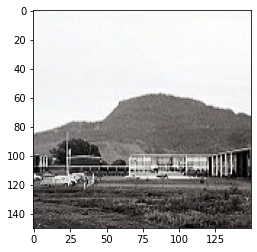

In [9]:
plt.imshow(img_test);

In [10]:
type(img_test)

numpy.ndarray

In [11]:
img_test

array([[[247, 247, 245],
        [247, 247, 245],
        [248, 248, 246],
        ...,
        [248, 248, 248],
        [247, 247, 245],
        [247, 247, 245]],

       [[246, 246, 244],
        [247, 247, 245],
        [247, 247, 245],
        ...,
        [248, 248, 248],
        [247, 247, 245],
        [247, 247, 245]],

       [[246, 246, 244],
        [246, 246, 244],
        [247, 247, 245],
        ...,
        [248, 248, 248],
        [247, 247, 245],
        [247, 247, 245]],

       ...,

       [[ 47,  46,  44],
        [ 62,  61,  59],
        [ 49,  48,  46],
        ...,
        [ 51,  46,  43],
        [ 45,  40,  37],
        [ 94,  89,  86]],

       [[ 77,  76,  74],
        [ 47,  46,  44],
        [ 43,  42,  40],
        ...,
        [ 22,  17,  14],
        [ 55,  50,  47],
        [ 39,  34,  31]],

       [[ 59,  58,  56],
        [ 55,  54,  52],
        [ 60,  59,  57],
        ...,
        [ 31,  26,  23],
        [ 51,  46,  43],
        [ 63,  58,  55]]

In [12]:
img_test.shape

(150, 150, 3)

In [13]:
# Look at one of the images that looks greyscale
img_test2 = mpimg.imread('./seg_train/seg_train/buildings/0.jpg')

In [14]:
#it has the same shape so is not stored in greyscale
img_test2.shape

(150, 150, 3)

Making sure all images have same shape, even ones that look greyscale

In [15]:
for file in filetest:
    img = mpimg.imread(f'./seg_train/seg_train/buildings/{file}')
    sh = img.shape
    if sh !=(150, 150, 3): 
        print('Ack!', file)

Ack! 5358.jpg


In [16]:
#image types list
image_types = ['buildings','forest','glacier','mountain','sea','street']

for itype in image_types:
    filelist = os.listdir(f"./seg_train/seg_train/{itype}")
    for file in filelist:
        img = mpimg.imread(f"./seg_train/seg_train/{itype}/{file}")
        if img.shape != (150, 150, 3): 
            print(itype,file, img.shape)

buildings 5358.jpg (124, 150, 3)
forest 1004.jpg (113, 150, 3)
forest 12108.jpg (108, 150, 3)
forest 14315.jpg (133, 150, 3)
forest 14609.jpg (115, 150, 3)
forest 15776.jpg (135, 150, 3)
forest 5483.jpg (136, 150, 3)
forest 5643.jpg (108, 150, 3)
forest 7174.jpg (113, 150, 3)
glacier 1010.jpg (110, 150, 3)
glacier 11110.jpg (105, 150, 3)
glacier 12634.jpg (111, 150, 3)
glacier 12983.jpg (120, 150, 3)
glacier 15103.jpg (149, 150, 3)
glacier 16472.jpg (143, 150, 3)
glacier 16710.jpg (146, 150, 3)
glacier 1740.jpg (134, 150, 3)
glacier 17528.jpg (142, 150, 3)
glacier 17611.jpg (123, 150, 3)
glacier 17654.jpg (119, 150, 3)
glacier 18110.jpg (102, 150, 3)
glacier 2837.jpg (76, 150, 3)
glacier 3148.jpg (97, 150, 3)
glacier 5135.jpg (111, 150, 3)
glacier 7410.jpg (111, 150, 3)
glacier 7512.jpg (135, 150, 3)
mountain 11873.jpg (134, 150, 3)
mountain 13200.jpg (135, 150, 3)
mountain 13656.jpg (123, 150, 3)
mountain 14462.jpg (113, 150, 3)
mountain 14575.jpg (142, 150, 3)
mountain 16041.jpg (144

We only have a small fraction of images that are not in the correct shape.  They are RGB but have different array sizes other than 150x150.  We will pad the images to be 150x150

#### Using the PIL library to resize an individual image

In [17]:
img_test = Image.open('./seg_train/seg_train/buildings/5358.jpg')

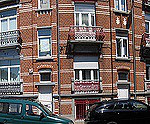

In [18]:
img_test

In [19]:
img_test.size

(150, 124)

In [20]:
new_img_test = img_test.resize((150,150),Image.ANTIALIAS)

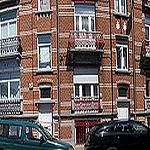

In [21]:
new_img_test

#### Writing a funcion to resize all images for a specific image type (folder)

In [22]:
#image types list
image_types = ['buildings','forest','glacier','mountain','sea','street']

# Function to gather up files into a dataframe based on subreddit name
# resizing based on: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def fix_image_size(imagetype, train_flag):
    filenames = os.listdir(f'./seg_{train_flag}/seg_{train_flag}/{imagetype}')#get list of files
    filenames = [file for file in filenames if 'clean' not in file]
    w, h = 150,150
    for file in filenames:
        #img = mpimg.imread(file)
        img = Image.open(f'./seg_{train_flag}/seg_{train_flag}/{imagetype}/{file}')
        if img.size != (150, 150): #grabbing the ones with  incorrect shape
            img = img.resize((150,150),Image.ANTIALIAS)
            
        img.save(f'./seg_{train_flag}/seg_{train_flag}/{imagetype}/clean_{file}')
            

In [23]:
#actually go into each folder and resize the improperly sized images
for itype in image_types:
    fix_image_size(itype,'train')
    fix_image_size(itype,'test')

In [24]:
#check for missized files
#image types list
image_types = ['buildings','forest','glacier','mountain','sea','street']

for itype in image_types:
    filelist = os.listdir(f"./seg_train/seg_train/{itype}")
    filelist = [file for file in filelist if 'clean' in file]
    for file in filelist:
        img = mpimg.imread(f"./seg_train/seg_train/{itype}/{file}")
        if img.shape != (150, 150, 3): 
            print(itype,file, img.shape)

We now have a full set of images that are the correct sizes in both train and test folders as long as we use the `clean_` files.    

In [25]:
#cleaning kaggle predictions folder as well
def fix_kaggle_image_size():
    filenames = os.listdir(f'./seg_pred/seg_pred/')#get list of files
    filenames = [file for file in filenames if 'clean' not in file]
    w, h = 150,150
    for file in filenames:
        #img = mpimg.imread(file)
        img = Image.open(f'./seg_pred/seg_pred/{file}')
        if img.size != (150, 150): #grabbing the ones with  incorrect shape
            img = img.resize((150,150),Image.ANTIALIAS)
            
        img.save(f'./seg_pred/seg_pred/clean_{file}')


In [26]:
fix_kaggle_image_size()

## Preprocessing
Importing cleaned images into dataframe

In [27]:
150*150*3

67500

In [28]:
# process all of our training and testing images into arrays
# referenced https://www.kdnuggets.com/2019/12/convert-rgb-image-grayscale.html

def get_all_images(train_flag):
    X = []
    y = []
    for imagetype in ['buildings','forest','glacier','mountain','sea','street']:
        filenames = os.listdir(f'./seg_{train_flag}/seg_{train_flag}/{imagetype}')#get list of files
        filenames = [file for file in filenames if 'clean' in file]
    
        for file in filenames:
            color_img = np.asarray(Image.open(
                f'./seg_{train_flag}/seg_{train_flag}/{imagetype}/{file}')) / 255
        
            #appending to lists (to be turned into arrays)
            X.append(color_img)
            y.append(imagetype)
        
        
    return X,y
        
        
        

In [29]:
#get our X_train and y_train
X_train,y_train = get_all_images('train')

In [30]:
#get our X_train and y_train
X_test,y_test = get_all_images('test')

In [31]:
#turn y_train into a classification
image_dict = {
    'buildings': 0,
    'forest': 1,
    'glacier':2,
    'mountain':3,
    'sea':4,
    'street':5
}

y_train = [image_dict[entry] for entry in y_train]
y_test = [image_dict[entry] for entry in y_test]

In [32]:
#convert to nparrays with float32 storage
X_train = np.array(X_train).astype('float32')
X_test  = np.array(X_test).astype('float32')

In [33]:
y_train = utils.to_categorical(y_train,6)
y_test = utils.to_categorical(y_test,6)

In [34]:
type(y_train[0][0])

numpy.float32

In [35]:
X_train.shape,y_train.shape

((14034, 150, 150, 3), (14034, 6))

In [36]:
X_test.shape,y_test.shape

((3000, 150, 150, 3), (3000, 6))

# Modeling


In [39]:
#instantiating the nn
model = Sequential()

# convolution & pooling
model.add(Conv2D(input_shape = (150,150,3),kernel_size = (3,3), filters=8, activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(kernel_size = (9,9), filters=16, activation='relu'))
model.add(MaxPooling2D(pool_size=(9,9)))

#flatten
model.add(Flatten())

#dense layers

model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(25,activation='relu'))

#output layer
model.add(Dense(6,activation='softmax'))

#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [40]:
history = model.fit(X_train,
          y_train, 
          validation_data=(X_test,y_test),
          epochs = 10,
          verbose = 1,
          batch_size = 256
         )

Epoch 1/10
55/55 [==============================] - 37s 665ms/step - loss: 1.3829 - accuracy: 0.4137 - val_loss: 1.1399 - val_accuracy: 0.5540
Epoch 2/10
55/55 [==============================] - 36s 653ms/step - loss: 1.0328 - accuracy: 0.5985 - val_loss: 0.9768 - val_accuracy: 0.6067
Epoch 3/10
55/55 [==============================] - 36s 660ms/step - loss: 0.8597 - accuracy: 0.6724 - val_loss: 0.8584 - val_accuracy: 0.6703
Epoch 4/10
55/55 [==============================] - 36s 647ms/step - loss: 0.7911 - accuracy: 0.7011 - val_loss: 0.8860 - val_accuracy: 0.6560
Epoch 5/10
55/55 [==============================] - 36s 663ms/step - loss: 0.7317 - accuracy: 0.7298 - val_loss: 0.7227 - val_accuracy: 0.7260
Epoch 6/10
55/55 [==============================] - 36s 653ms/step - loss: 0.6736 - accuracy: 0.7517 - val_loss: 0.6759 - val_accuracy: 0.7537
Epoch 7/10
55/55 [==============================] - 36s 647ms/step - loss: 0.6300 - accuracy: 0.7703 - val_loss: 0.6848 - val_accuracy: 0.7410

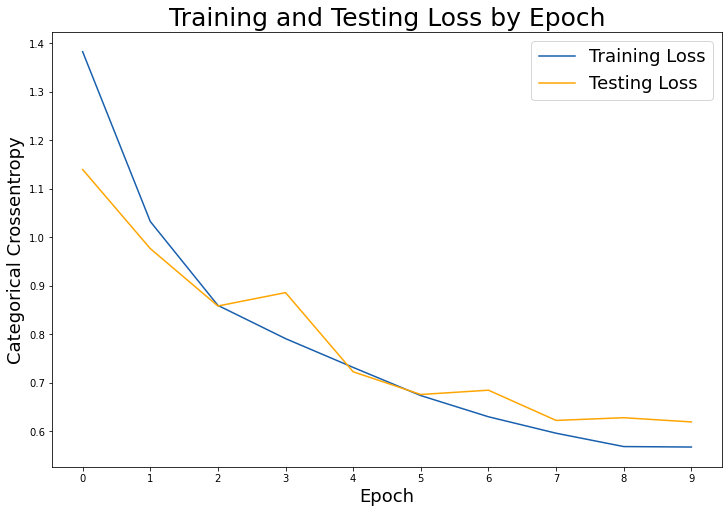

In [41]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

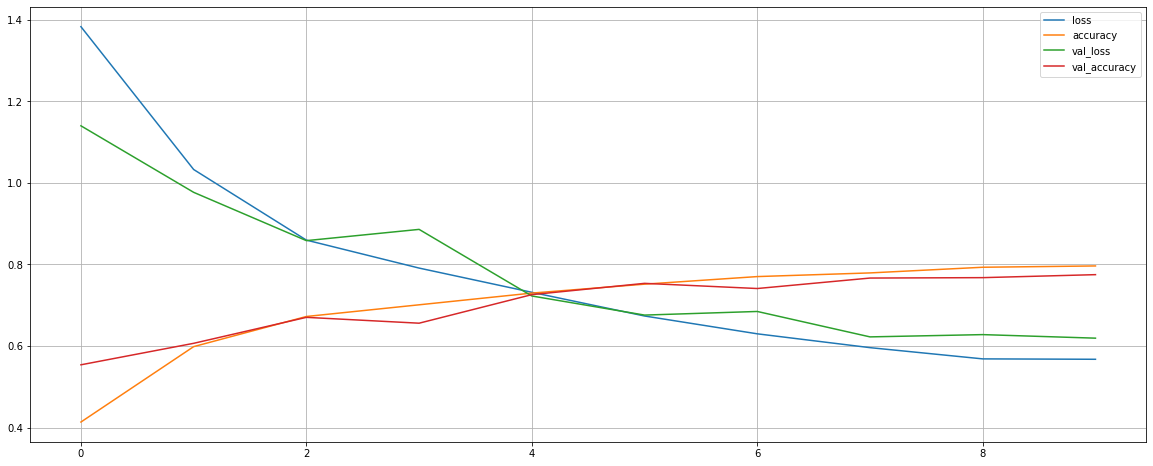

In [42]:
pd.DataFrame(history.history).plot(figsize = (20,8))

plt.grid(True)
plt.gca().set_ylim()
plt.show()

## Kaggle predictions

In [63]:
# similar function to get_all_images but for kaggle predictions (no y)
def get_kaggle_images():
    X = []
    kaggle_id = []
    
    filenames = os.listdir(f'./seg_pred/seg_pred')#get list of files
    filenames = [file for file in filenames if 'clean' not in file]
    
    for file in filenames:
        color_img = Image.open(
                f'./seg_pred/seg_pred/{file}')
            
        if color_img.size != (150, 150): #grabbing the ones with  incorrect shape
            color_img = color_img.resize((150,150),Image.ANTIALIAS)
        if color_img.size != (150, 150):
            print('oops')
            
        color_img = np.asarray(color_img)/255
        #appending to lists (to be turned into arrays)
        X.append(color_img)
        kaggle_id.append(file)
            
    return X, kaggle_id

In [64]:
X_kaggle, id_kaggle = get_kaggle_images()

In [65]:
X_kaggle = np.array(X_kaggle).astype('float32')

In [66]:
# use model predictor
predictions = model.predict(X_kaggle, batch_size = 256)

In [67]:
# use the location for the prediction
y_kaggle = [np.argmax(i) for i in predictions]

In [71]:
kaggle_output = {'Image':id_kaggle, 'Prediction':y_kaggle}

In [72]:
pd.DataFrame(kaggle_output).to_csv('kaggle_submission.csv',index=False)